# PR Forecast 2082: Data & Feature Overview

This notebook documents the data foundation for forecasting Nepal’s **2082 Proportional Representation (PR)** election outcome.

**What this notebook covers**
- The main modeling tables used for PR forecasting (training + 2082 inference)
- Unit of analysis and target definition
- Feature groups (political inertia, demographics, turnout, digital presence)
- Sanity checks (shape, missingness, distributions)

**What this notebook does NOT do**
- Model training (kept in `scripts/` + `src/` for reproducibility)
- Seat allocation scenarios (covered in a later notebook)


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", 300)
pd.set_option("display.max_rows", 50)


In [12]:
import os
os.chdir(r"C:\Users\dipes\Desktop\election-analytics-nepal-2082")
print(os.getcwd())

C:\Users\dipes\Desktop\election-analytics-nepal-2082


In [13]:
TRAIN_PATH = "data/processed/pr_train_2079.csv"
INFER_PATH = "data/processed/pr_infer_2082.csv"
PRED_NATL_PATH = "data/outputs/pr_predictions_national_2082.csv"
SOCIAL_PATH = "data/processed/sentiment_party_national_2082.csv"


In [14]:
train = pd.read_csv(TRAIN_PATH)
infer = pd.read_csv(INFER_PATH)
social = pd.read_csv(SOCIAL_PATH)
train.shape, infer.shape, social.shape


((3619, 34), (6622, 33), (15, 16))

## Core modeling tables

This project uses three core tables in the PR pipeline:

1. **Training table (`pr_train_2079.csv`)**
   - Unit: **district × party** (rows include multiple parties per district)
   - Year: **2079**
   - Includes **lag features from 2074** (e.g., `vote_share_lag`) to model change over time.

2. **Inference table (`pr_infer_2082.csv`)**
   - Unit: **district × party**
   - Year: **2082**
   - Includes many **new parties**, so the party count is larger than training.

3. **Social summary (`sentiment_party_national_2082.csv`)**
   - Unit: **party**
   - Aggregated Facebook engagement stats (posts, reactions, video views)
   - Used only as a **bounded scenario overlay** later (not as a direct vote predictor).


In [15]:
train.head(3)


,district_id,party_id,election_year,vote_share,vote_share_lag,vote_share_change,is_new_party,Absent rate within country 2078,Absent rate abroad 2078,Literacy Rate 2078,Primary Education % 2078,Lower Secondary % 2078,Upper Secondary % 2078,SLC or SEE % 2078,Intermediate & equivalent % 2078,Graduate & equivalent % 2078,Post graduate equivalent & above % 2078,IS_ALTERNATIVE_FORCE?,GenZ_and_Youth_Favored?,Was_Part_Of_Ousted_Government?,IS_Major?,Facebook_Presence (In Thousands),Top_leader_fb (in Thousands),age_18-29_ratio,age_30-39_ratio,age_40-49_ratio,age_50-59_ratio,age_60-69_ratio,age_70+_ratio,female_ratio,valid_turnout,valid_turnout_lag,facebook_log,leader_following_log
0,1,P001,2079,42.369621,44.075145,-1.705523,0,7.14,5.17,82.21,30.53,21.99,19.39,9.24,9.82,2.58,1.07,0,0,1,1,350.0,650.0,0.208919,0.26093,0.179692,0.141929,0.113764,0.094767,0.466727,52.41,60.02,5.860786,6.478510
1,1,P002,2079,34.007651,31.449762,2.557889,0,7.14,5.17,82.21,30.53,21.99,19.39,9.24,9.82,2.58,1.07,0,0,1,1,300.0,621.0,0.208919,0.26093,0.179692,0.141929,0.113764,0.094767,0.466727,52.41,60.02,5.707110,6.432940
2,1,P003,2079,11.156498,13.475434,-2.318936,0,7.14,5.17,82.21,30.53,21.99,19.39,9.24,9.82,2.58,1.07,0,0,1,1,160.0,700.0,0.208919,0.26093,0.179692,0.141929,0.113764,0.094767,0.466727,52.41,60.02,5.081404,6.552508


In [16]:
infer.head(3)


,party_id,district_id,election_year,vote_share_lag,is_new_party,Absent rate within country 2078,Absent rate abroad 2078,Literacy Rate 2078,Primary Education % 2078,Lower Secondary % 2078,Upper Secondary % 2078,SLC or SEE % 2078,Intermediate & equivalent % 2078,Graduate & equivalent % 2078,Post graduate equivalent & above % 2078,IS_Major?,IS_ALTERNATIVE_FORCE?,GenZ_and_Youth_Favored?,Was_Part_Of_Ousted_Government?,Facebook_Presence (In Thousands),Top_leader_fb (in Thousands),facebook_log,leader_following_log,female_ratio,age_18-29_ratio,age_30-39_ratio,age_40-49_ratio,age_50-59_ratio,age_60-69_ratio,age_70+_ratio,total_voters,valid_turnout,valid_turnout_lag
0,P001,1,2082,42.369621,0,7.14,5.17,82.21,30.53,21.99,19.39,9.24,9.82,2.58,1.07,1,0,0,1,374,710,5.926926,6.566672,0.465442,0.208919,0.26093,0.179692,0.141929,0.113764,0.094767,90327,52.41,52.41
1,P002,1,2082,34.007651,0,7.14,5.17,82.21,30.53,21.99,19.39,9.24,9.82,2.58,1.07,1,0,0,1,32,621,3.496508,6.432940,0.465442,0.208919,0.26093,0.179692,0.141929,0.113764,0.094767,90327,52.41,52.41
2,P003,1,2082,14.499989,0,7.14,5.17,82.21,30.53,21.99,19.39,9.24,9.82,2.58,1.07,1,0,0,0,174,756,5.164786,6.629363,0.465442,0.208919,0.26093,0.179692,0.141929,0.113764,0.094767,90327,52.41,52.41


In [17]:
social.head(3)


,party_id,num_posts,avg_react_Like,avg_react_Love,avg_react_Haha,avg_react_Wow,avg_react_Sad,avg_react_Angry,avg_react_Care,num_video_posts,avg_video_views,median_video_views,total_reactions,avg_reactions_total,total_followers,avg_followers_total
0,P001,46,7098.521739,535.260870,6295.282609,21.956522,21.673913,425.739130,63.978261,12,129566.66670,20474.5,665271,14462.413040,15459000,336065.2174
1,P002,35,11825.028570,1684.800000,558.371429,13.257143,9.314286,27.514286,101.485714,6,190016.50000,122223.5,497692,14219.771430,10987000,313914.2857
2,P003,33,2972.606061,209.969697,125.696970,1.969697,37.121212,3.363636,18.545455,15,44841.06667,54198.0,111186,3369.272727,11135000,337424.2424


In [18]:
train["district_id"].nunique(), train["party_id"].nunique(), len(train)


(77, 47, 3619)

In [19]:
infer["district_id"].nunique(), infer["party_id"].nunique(), len(infer)


(77, 86, 6622)

In [20]:
(train.isna().mean().sort_values(ascending=False).head(20) * 100).round(2)


district_id                                0.0
age_40-49_ratio                            0.0
Was_Part_Of_Ousted_Government?             0.0
IS_Major?                                  0.0
Facebook_Presence (In Thousands)           0.0
Top_leader_fb (in Thousands)               0.0
age_18-29_ratio                            0.0
age_30-39_ratio                            0.0
age_50-59_ratio                            0.0
party_id                                   0.0
age_60-69_ratio                            0.0
age_70+_ratio                              0.0
female_ratio                               0.0
valid_turnout                              0.0
valid_turnout_lag                          0.0
facebook_log                               0.0
GenZ_and_Youth_Favored?                    0.0
IS_ALTERNATIVE_FORCE?                      0.0
Post graduate equivalent & above % 2078    0.0
Graduate & equivalent % 2078               0.0
dtype: float64

## Target definition (supervised learning)

The PR model predicts **vote share change** rather than raw vote share:

- `vote_share_lag` = party vote share in the previous election (2074) within the same district  
- `vote_share` = party vote share in the next election (2079) within the same district  
- `vote_share_change` = `vote_share - vote_share_lag`

This makes the model easier to generalize because it learns:
- momentum vs mean reversion
- how demographics/turnout relate to swings
- how new parties behave relative to historical baselines

In 2082 inference, the predicted district vote share is reconstructed as:
`pred_vote_share = vote_share_lag + pred_vote_share_change` (then clipped to [0, 100]).


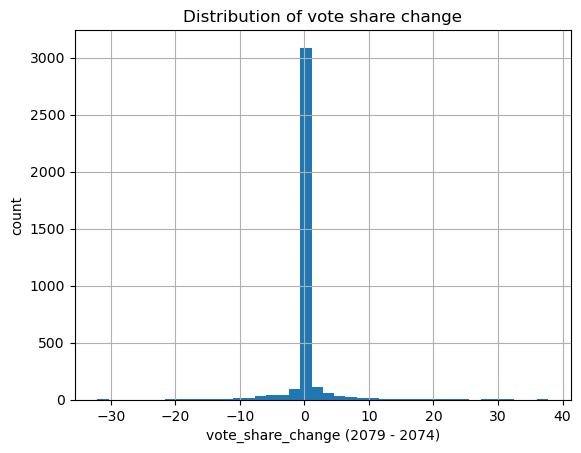

In [21]:
plt.figure()
train["vote_share_change"].hist(bins=40)
plt.xlabel("vote_share_change (2079 - 2074)")
plt.ylabel("count")
plt.title("Distribution of vote share change")
plt.show()


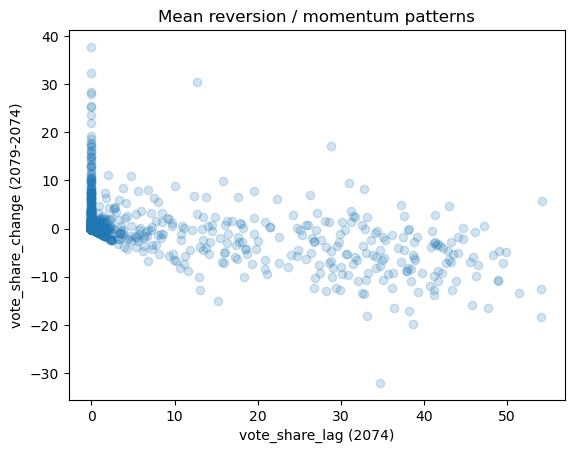

In [22]:
plt.figure()
plt.scatter(train["vote_share_lag"], train["vote_share_change"], alpha=0.2)
plt.xlabel("vote_share_lag (2074)")
plt.ylabel("vote_share_change (2079-2074)")
plt.title("Mean reversion / momentum patterns")
plt.show()


## Feature groups

Features are organized into interpretable groups:

**Political inertia**
- `vote_share_lag`, party flags (major / alternative / ousted govt / youth favored), new party indicator

**Demographics (Census 2078)**
- age composition (youth density, working age)
- gender ratio

**Education**
- literacy rate
- mid-level education (SEE + Intermediate)
- higher education (Graduate+)

**Migration**
- absent within country
- absent abroad

**Turnout / mobilization**
- lagged valid turnout 

**Digital visibility**
- leader following (log scale)

This structure makes the feature set explainable in interviews and easy to audit for leakage.


## Derived features used by the model

To reduce noise and improve interpretability, several “compressed” demographic/education features are created:

- `under_40_ratio` = age 18–29 + age 30–39  
- `40-60_ratio` = age 40–49 + age 50–59  
- `SEE_Inter` = SEE/SLC + Intermediate  
- `Grad_plus` = Graduate + Postgraduate  

These derived features are used consistently in training and inference to avoid mismatch.


In [23]:
train = train.copy()
infer = infer.copy()

for df in [train, infer]:
    df["under_40_ratio"] = df["age_18-29_ratio"] + df["age_30-39_ratio"]
    df["40-60_ratio"] = df["age_40-49_ratio"] + df["age_50-59_ratio"]
    df["SEE_Inter"] = df["SLC or SEE % 2078"] + df["Intermediate & equivalent % 2078"]
    df["Grad_plus"] = df["Graduate & equivalent % 2078"] + df["Post graduate equivalent & above % 2078"]


In [24]:
FEATURES = [
    "vote_share_lag",
    "is_new_party",
    "IS_Major?",
    "IS_ALTERNATIVE_FORCE?",
    "Was_Part_Of_Ousted_Government?",
    "GenZ_and_Youth_Favored?",
    "under_40_ratio",
    "40-60_ratio",
    "female_ratio",
    "Literacy Rate 2078",
    "SEE_Inter",
    "Grad_plus",
    "Absent rate within country 2078",
    "Absent rate abroad 2078",
    "valid_turnout_lag",
    "leader_following_log"
]
len(FEATURES)


16

In [25]:
missing_train = [c for c in FEATURES if c not in train.columns]
missing_infer = [c for c in FEATURES if c not in infer.columns]
missing_train, missing_infer


([], [])

In [26]:
train[FEATURES].describe().T[["mean", "std", "min", "max"]].round(3).head(20)


,mean,std,min,max
vote_share_lag,2.035,7.673,0.000,54.201
is_new_party,0.511,0.500,0.000,1.000
IS_Major?,0.085,0.279,0.000,1.000
IS_ALTERNATIVE_FORCE?,0.085,0.279,0.000,1.000
Was_Part_Of_Ousted_Government?,0.106,0.308,0.000,1.000
GenZ_and_Youth_Favored?,0.021,0.144,0.000,1.000
under_40_ratio,0.432,0.034,0.318,0.508
40-60_ratio,0.348,0.021,0.310,0.405
female_ratio,0.493,0.018,0.437,0.526
Literacy Rate 2078,75.732,6.654,57.750,89.230


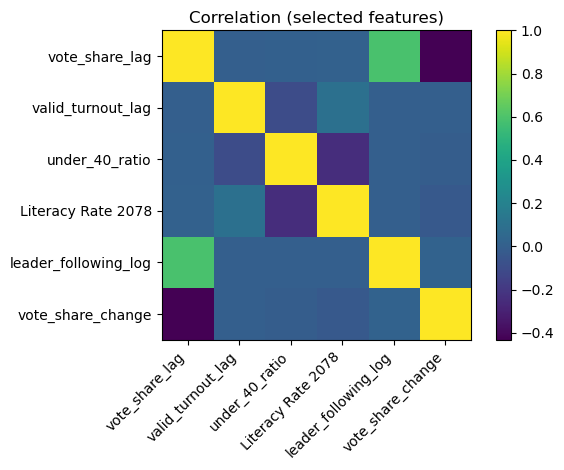

In [27]:
cols = ["vote_share_lag", "valid_turnout_lag", "under_40_ratio", "Literacy Rate 2078", "leader_following_log", "vote_share_change"]
corr = train[cols].corr()

plt.figure()
plt.imshow(corr, interpolation="nearest")
plt.xticks(range(len(cols)), cols, rotation=45, ha="right")
plt.yticks(range(len(cols)), cols)
plt.colorbar()
plt.title("Correlation (selected features)")
plt.tight_layout()
plt.show()


## Quick correlation scan (sanity check)

This correlation view is not used to “select features” automatically. It is a sanity check to confirm:

- no obvious leakage (e.g., target-like features)
- relationships make political sense (e.g., lag share correlates with future share)
- turnout / demographics are not trivially duplicating the target

The model pipeline still relies on backtesting for validation rather than correlations alone.


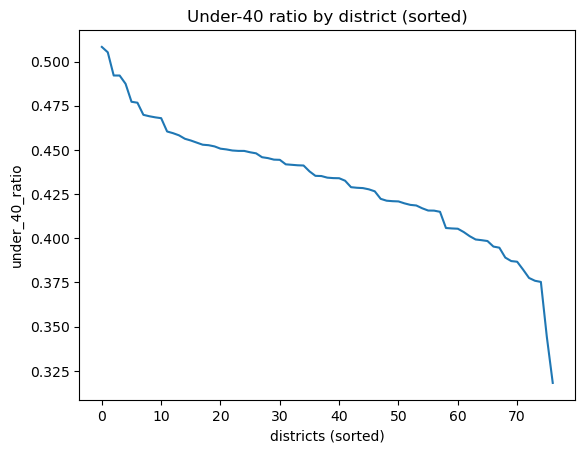

In [28]:
district_demo = train.groupby("district_id")[["under_40_ratio", "Literacy Rate 2078"]].mean().reset_index()
district_demo = district_demo.sort_values("under_40_ratio", ascending=False)

plt.figure()
plt.plot(district_demo["under_40_ratio"].values)
plt.title("Under-40 ratio by district (sorted)")
plt.xlabel("districts (sorted)")
plt.ylabel("under_40_ratio")
plt.show()


In [29]:
flag_cols = ["IS_Major?", "IS_ALTERNATIVE_FORCE?", "Was_Part_Of_Ousted_Government?", "GenZ_and_Youth_Favored?", "is_new_party"]
train[flag_cols].astype(int).mean().sort_values(ascending=False)


is_new_party                      0.510638
Was_Part_Of_Ousted_Government?    0.106383
IS_Major?                         0.085106
IS_ALTERNATIVE_FORCE?             0.085106
GenZ_and_Youth_Favored?           0.021277
dtype: float64

## Party flags (political context variables)

Several party-level flags are included to capture non-demographic structure:

- **Major party**: historically large, established parties  
- **Alternative force**: parties positioned as anti-establishment / reformist  
- **Part of ousted government**: parties associated with the collapsed government  
- **GenZ / youth favored**: heuristic indicator for youth-backed parties  
- **New party**: limited or no historical vote share baseline

These flags are imperfect proxies, but they help the model encode political structure
that pure demographics cannot capture.


In [30]:
natl_2079 = train.groupby("party_id")["vote_share"].mean().sort_values(ascending=False)
natl_2079.head(15).sum(), natl_2079.sum()


(np.float64(97.83106096629707), np.float64(99.99999999999999))

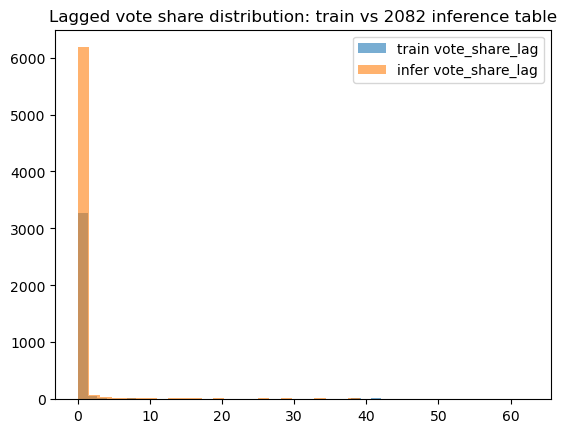

In [31]:
plt.figure()
plt.hist(train["vote_share_lag"], bins=40, alpha=0.6, label="train vote_share_lag")
plt.hist(infer["vote_share_lag"], bins=40, alpha=0.6, label="infer vote_share_lag")
plt.legend()
plt.title("Lagged vote share distribution: train vs 2082 inference table")
plt.show()


## Distribution shift: training vs 2082 inference

The 2082 election environment is structurally different:

- more parties contesting
- weaker historical baselines for new parties
- likely higher volatility due to political shocks

This notebook does not “fix” the shift—this is addressed later using:
- consolidation scenarios for micro-parties
- optional sentiment tilt / backlash penalties as bounded overlays

The key point here is to acknowledge the shift and make it explicit.


In [32]:
social = social.copy()
social["eng_rate"] = social["avg_reactions_total"] / social["avg_followers_total"].replace(0, np.nan)
social["neg_share"] = (social["avg_react_Angry"] + social["avg_react_Sad"]) / social["avg_reactions_total"].replace(0, np.nan)
social[["party_id", "eng_rate", "neg_share", "num_posts", "avg_video_views"]].sort_values("eng_rate", ascending=False).head(10)


,party_id,eng_rate,neg_share,num_posts,avg_video_views
3,P004,0.087758,0.000447,36,218374.57140
9,P011,0.052262,0.000759,15,2371.00000
1,P002,0.045298,0.002590,35,190016.50000
0,P001,0.043035,0.030936,46,129566.66670
13,P057,0.036210,0.000289,20,6579.00000
11,P032,0.026550,0.000050,23,10500.33333
5,P006,0.010965,0.000591,21,38.00000
4,P005,0.010621,0.001708,70,47708.57692
8,P010,0.010337,0.000000,1,0.00000
2,P003,0.009985,0.012016,33,44841.06667


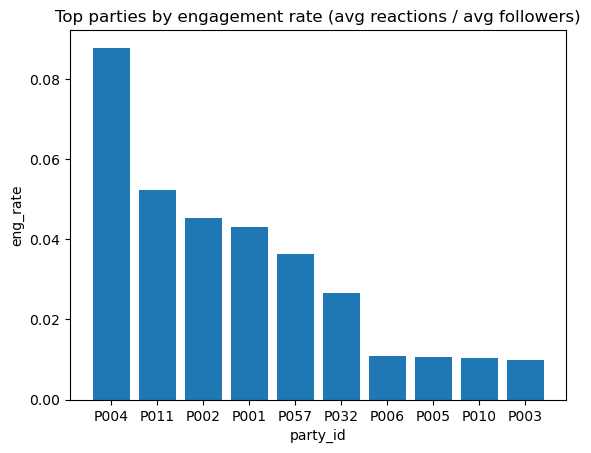

In [33]:
top = social.sort_values("eng_rate", ascending=False).head(10)

plt.figure()
plt.bar(top["party_id"], top["eng_rate"].values)
plt.title("Top parties by engagement rate (avg reactions / avg followers)")
plt.xlabel("party_id")
plt.ylabel("eng_rate")
plt.show()


## Social media summary table (how it is used)

The social media table is **not** assumed to represent the electorate.

It is used only for **scenario overlays** to answer questions like:
- “If late-stage coordination happens, who benefits more among viable parties?”
- “How might backlash (negative reactions) reduce consolidation into incumbents?”

Important limitations:
- platform users are not representative of all voters
- reactions do not equal votes
- page size and content type influence engagement heavily

To reduce bias, we prefer using:
- engagement rates (reactions per follower)
- standardized scores (z-scores)
- bounded effects (small alpha unless a shock scenario is explicitly modeled)


In [34]:
plt.savefig("data/outputs/figures/feature_corr.png", dpi=200, bbox_inches="tight")


<Figure size 640x480 with 0 Axes>

## Summary & next steps

In this notebook we:
- loaded the training and inference modeling tables for PR forecasting
- defined the unit of analysis (district × party) and target (`vote_share_change`)
- reviewed feature groups and derived features used in the model
- ran sanity checks for missingness, distributions, and basic relationships
- introduced the social summary table and clarified how it is used (scenario overlay)

**Next notebook:** `02_pr_model_backtesting.ipynb`  
- district-holdout evaluation (GroupKFold / GroupShuffleSplit)
- prediction error analysis by party size
- evidence that the model generalizes beyond simple lag-copying
